## Importando bibliotecas e módulos necessários

In [1]:
import random
import re
import string
import unidecode

from pprint import pprint

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

In [2]:
# Configuração de exibição do DataFrame no pandas
pd.set_option('display.max_colwidth', None) # exibe todo o conteúdo das células

# Função para reproducibilidade dos resultados
def set_seeds(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds()

## Análise exploratória

In [3]:
# Carrega somente as colunas contendo os tweets e variável alvo da base de dados de treino 
train_data = pd.read_csv('./data/Corona_NLP_train.csv', encoding='latin-1', usecols=['OriginalTweet', 'Sentiment'])

# Carrega somente as colunas contendo os tweets e variável alvo da base de dados de teste 
test_data = pd.read_csv('./data/Corona_NLP_test.csv', usecols=['OriginalTweet', 'Sentiment'])

In [4]:
# Exibe as dimensões da base de treino
print(f'A base de treino possui {train_data.shape[0]} linhas e {train_data.shape[1]} colunas')

# Exibe as dimensões da base de teste
print(f'\nA base de teste possui {test_data.shape[0]} linhas e {test_data.shape[1]} colunas')

A base de treino possui 41157 linhas e 2 colunas

A base de teste possui 3798 linhas e 2 colunas


## Distribuição de classes da variável alvo

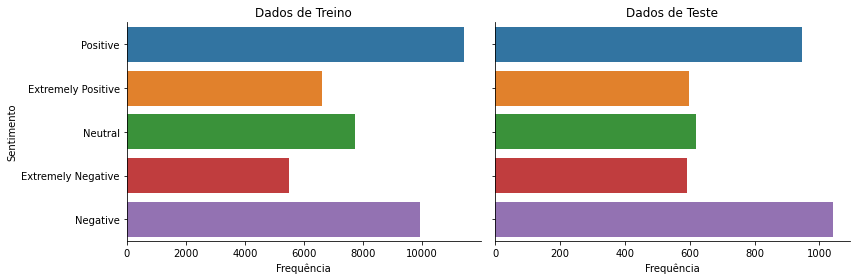

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

order = ['Positive', 'Extremely Positive', 'Neutral', 'Extremely Negative', 'Negative']

sns.countplot(y='Sentiment', data=train_data, order=order, ax=ax[0])
ax[0].set(xlabel='Frequência', ylabel='Sentimento', title='Dados de Treino')

sns.countplot(y='Sentiment', data=test_data, order=order, ax=ax[1])
ax[1].set(xlabel='Frequência', ylabel=None, title='Dados de Teste')

sns.despine()
plt.tight_layout();


## Pré-processamento de texto

In [6]:
### Tentamos deixar tudo que pode ser realizado fora da função a fim de otimizarmos o código
# Expressões regulares
remove_urls     = re.compile(r'https?://\S+|www\.\S+')
remove_hashtags = re.compile(r'#\w+')
remove_emails   = re.compile(r'\S+@\S+')
remove_rt       = re.compile(r'^RT[\s]+')
remove_numbers  = re.compile(r'\d+')

# Carrega "stopwords" da bliblioteca NLTL
nltk_stop_words = stopwords.words('english')

# Carrega a pontuação
punctuation = string.punctuation

# Instancia o TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False,  # transforma em minúsculas
                       strip_handles=True,   # remove citaçãoes
                       reduce_len=True)      # reduz caracteres repetidos


def preprocess_text(text):

    # Apply regex
    text = remove_urls.sub('', text)        # remove urls

    # Parse HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    text = remove_hashtags.sub('', text)    # remove hashtags    

    text = remove_emails.sub('', text)      # remove emails

    text = remove_rt.sub('', text)          # remove RT
    
    # Encoding-decoding text
    text = text.encode('ascii', 'replace').decode('utf-8') 

    # Tokenização
    tokens = tknzr.tokenize(text)

    ## Stop words NLTK
    # tokens = [token for token in tokens if token not in nltk_stop_words]

    # Stemming
    # tokens = [PorterStemmer().stem(token) for token in tokens]

    # Remove palavras não alfabétivas (números, pontuação, caractéres especiais etc)
    # ou que possuam apenas hum caractér
    tokens = [token for token in tokens if token.isalpha() and len(token) > 1]
    
    return ' '.join(tokens)

In [7]:
# Exemplo de pré-processamento do texto
print('Texto original', '-' * 15, train_data.loc[40370, "OriginalTweet"], '', 
      'Texto limpo', '-' * 15,  preprocess_text(train_data.loc[40370, "OriginalTweet"]), sep='\n')

Texto original
---------------
ÂWe created an interactive map of direct-to-consumer brands based in NYC to illustrate the true creative energy of the city, the way it was before coronavirus and the way it will return soon.Â - Chris Nager @airHQ #Covid19 https://t.co/STND1yS2Ry #builtwithmapbox #NYCstrong https://t.co/C540HeBTYx

Texto limpo
---------------
we created an interactive map of brands based in nyc to illustrate the true creative energy of the city the way it was before coronavirus and the way it will return soon chris nager


In [8]:
%%time
# Pré-processa a base de treino
train_data['tweet'] = train_data['OriginalTweet'].apply(preprocess_text)

# Pré-processa a base de teste
test_data['tweet'] = test_data['OriginalTweet'].apply(preprocess_text)

Wall time: 15.8 s


In [9]:
train_data.head(3)

,OriginalTweet,Sentiment,tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,and and
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak


## Tratamento de dados faltantes após o pré-processamento

In [10]:
# Substitui as colunas vazias por "NaN": base de treino
train_data.loc[train_data['tweet'] == '', ['tweet']]= np.nan

# Substitui as colunas vazias por "NaN": base de teste
test_data.loc[test_data['tweet'] == '', ['tweet']]= np.nan

In [11]:
# Verifica se há dados faltantes na base de treino
print('Base de treino', '-' * 15 , train_data.isna().sum(), sep='\n')

# Verifica se há dados faltantes na base de teste
print('\nBase de teste', '-' * 15, test_data.isna().sum(), sep='\n')

Base de treino
---------------
OriginalTweet     0
Sentiment         0
tweet            39
dtype: int64

Base de teste
---------------
OriginalTweet    0
Sentiment        0
tweet            2
dtype: int64


In [12]:
# Remove os dados faltantes da base de treino
train_data.dropna(inplace=True)

# Remove os dados faltantes da base de teste
test_data.dropna(inplace=True)

In [13]:
# Sanity check
print('Base de treino', '-' * 15, train_data.isna().sum(),
      '\nBase de teste', '-' * 15, train_data.isna().sum(), sep='\n')

Base de treino
---------------
OriginalTweet    0
Sentiment        0
tweet            0
dtype: int64

Base de teste
---------------
OriginalTweet    0
Sentiment        0
tweet            0
dtype: int64


## Tratamento de classes da variável alvo

In [14]:
# Reduz a quantidade de classes de 5(cinco) para 3(três), 
# substituindo a classe "Extremely Negative" por "Negative"
# e a classe "Extremely Positive" por "Positive": base de treino
train_data['Sentiment'].replace({'Extremely Negative': 'Negative', 'Extremely Positive': 'Positive'}, inplace=True)

# Realiza o mesmo procedimento para os dados de teste
test_data['Sentiment'].replace({'Extremely Negative': 'Negative', 'Extremely Positive': 'Positive'}, inplace=True)

## Distribuição de classes da variável alvo após agrupamento de classes

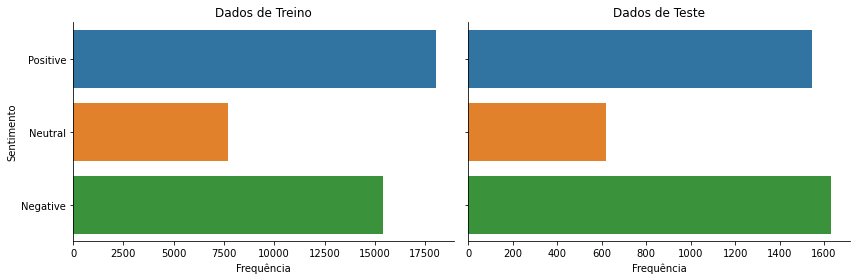

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

order = ['Positive', 'Neutral', 'Negative']

sns.countplot(y='Sentiment', data=train_data, order=order, ax=ax[0])
ax[0].set(xlabel='Frequência', ylabel='Sentimento', title='Dados de Treino')

sns.countplot(y='Sentiment', data=test_data, order=order, ax=ax[1])
ax[1].set(xlabel='Frequência', ylabel=None, title='Dados de Teste')

sns.despine()
plt.tight_layout();

## Frequência de palavras

In [16]:
# Compute the word frequency
corpus = ' '.join(train_data['tweet'])
fdist = nltk.FreqDist(word_tokenize(corpus))

In [17]:
# Exibe as ciquenta palavras mais comuns na base de treino
# após o pré-processamento do texto
pprint(fdist.most_common(50), compact=True)

[('the', 44857), ('to', 38365), ('and', 24079), ('of', 21518), ('in', 19163),
 ('for', 14059), ('is', 12264), ('are', 11351), ('covid', 10613), ('you', 9625),
 ('on', 9410), ('this', 7987), ('prices', 7847), ('at', 7789), ('food', 6835),
 ('store', 6820), ('supermarket', 6700), ('with', 6637), ('we', 6553),
 ('it', 6453), ('that', 6443), ('have', 6156), ('as', 6111), ('grocery', 6087),
 ('be', 5752), ('people', 5549), ('from', 5293), ('all', 4888), ('not', 4773),
 ('your', 4601), ('will', 4501), ('can', 4386), ('consumer', 4298),
 ('my', 4206), ('our', 4052), ('they', 4012), ('has', 3804), ('out', 3793),
 ('up', 3788), ('or', 3736), ('by', 3724), ('more', 3719), ('but', 3570),
 ('if', 3555), ('shopping', 3371), ('online', 3353), ('how', 3331),
 ('their', 3227), ('during', 3205), ('now', 3104)]


In [18]:
# Exibe a quantidade de palavras raras no vocabulário
rare_words = [name for name, freq in fdist.items() if freq == 1] 
print(f'Essa base de dados possui {len(rare_words)} palavras que ocorrem somente uma vez.')

Essa base de dados possui 14692 palavras que ocorrem somente uma vez.


## Gráfico da distribuição de frequência da quantidade de palavras utilizadas por tweet

In [19]:
train_data['word_count'] = train_data['tweet'].apply(lambda row: len(row.split()))
train_data.head()

,OriginalTweet,Sentiment,tweet,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,and and,2
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order,38
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak,13
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,my food stock is not the only one which is empty please panic there will be enough food for everyone if you do not take more than you need stay calm stay safe,33
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Negative,me ready to go at supermarket during the outbreak not because paranoid but because my food stock is litteraly empty the is serious thing but please panic it causes shortage,30


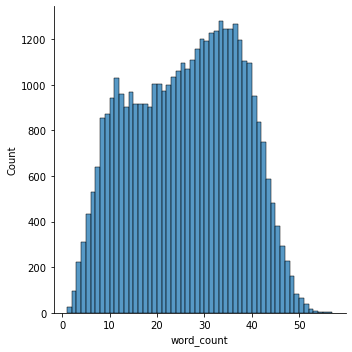

In [20]:
bins = [*set(train_data['word_count'])]
sns.displot(x='word_count',
            bins=bins,
            data=train_data);

## Preparação dos dados para o modelo

In [21]:
# Cria um índice de palavras utilizando a base de treino
tokenizer = Tokenizer(oov_token='<UNK>') # oov_token = 'out of vocabulary'; palavras fora do vocabulário
                                         # serão substituídas por esse tokenizador "especial": '<UNK>' (abreviação para "unknown")

tokenizer.fit_on_texts(train_data['tweet'])

# Armazena o dicionário de índices criados
word_index = tokenizer.word_index

In [22]:
pad_sequences_args = {'maxlen'    : 50,      # tamanho máximo dos vetores - escolhido de acordo com a distribuição 
                                             # de frquência de palavras utilizadas nos tweets

                      'padding'   :'post',   # vetores menores que o "maxlen" serão preenchidos com 0 (zeros)
                                             # ao final 

                      'truncating': 'post'}  # vetores maiores que o "maxlen" serão truncados ao final


# Transforma os textos em sequência de vetores de mesmo tamanho
X_train_seq = tokenizer.texts_to_sequences(train_data['tweet'])
X_train =  pad_sequences(X_train_seq, **pad_sequences_args)


# Realiza o mesmo procedimento para os dados de teste
X_test_seq = tokenizer.texts_to_sequences(test_data['tweet'])
X_test = pad_sequences(X_test_seq, **pad_sequences_args)

In [23]:
print(
    # X_train.shape,
    'Exemplo de texto pré-processado', '-' * 35, train_data.loc[2, 'tweet'],
    '\nExemplo do mesmo texto vetorizado', '-' * 35, X_train[2], sep='\n')

Exemplo de texto pré-processado
-----------------------------------
coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak

Exemplo do mesmo texto vetorizado
-----------------------------------
[  76  871 4230    3  295  306 1375 1711   46  252  151   10  130    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [24]:
# Transformação das classes da variável alvo em dados numéricos
le = LabelEncoder()
y_train = le.fit_transform(train_data['Sentiment'])  # treino
y_test  = le.fit_transform(test_data['Sentiment'])   # teste

# armazena o nome dos atributos e classe
target_names = le.classes_

print(target_names, y_train, sep='\n\n')

['Negative' 'Neutral' 'Positive']

[1 2 2 ... 2 1 0]


In [25]:
# Sanity check
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((41118, 50), (41118,), (3796, 50), (3796,))

## Vetores de palavras pré-treinados - GloVe

In [26]:
%%time
# Parse the GloVe word-embeddings file
embeddings_index = {}

with open('glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word   = values[0]
        coefs  = np.array(values[1:], dtype=np.float32)
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')
print('---\n')

# Prepare the GloVe word-embeddings matrix
vocab_size = len(word_index) + 1  # O "+1" se refere ao índice 0 (zero) relacionado ao processo de "padding"
embedding_dim = 200

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(f'Embeddings matrix dimensions: {embeddings_matrix.shape[0]} rows and {embeddings_matrix.shape[1]} columns')

Found 1193514 word vectors.
---

Embeddings matrix dimensions: 31926 rows and 200 columns
Wall time: 1min 21s


## Treinamento e validação do modelo

In [27]:
# Fixa uma semente para reproducibilidade do modelo
tf.keras.backend.clear_session()
set_seeds()

# Modelo
model = tf.keras.Sequential([

        # Cria a dimensão com os vetores de palavras
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  input_length=X_train.shape[1],
                                  weights=[embeddings_matrix],
                                  trainable=False),

        # Primeira camada LSTM bidirecional
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                           dropout=0.2, 
                                                           # recurrent_dropout=0.3, # incompatibilidade com CUDA;
                                                                                    # torna o treinamento do modelo muito lento
                                                           return_sequences=True)),

        # Segunda camada LSTM bidirecional
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                           dropout=0.1,
                                                           return_sequences=True)),

        tf.keras.layers.GlobalMaxPool1D(),

        tf.keras.layers.Dense(256, activation='relu'),

        # Camada final para as 3 (três) categorias que se deseja prever
        tf.keras.layers.Dense(3, activation='softmax'),
])

# Compila o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss='sparse_categorical_crossentropy',  # utilizado quando não se usa "one-hot-encoder"  
                                                       # para transformar a variável alvo 
              metrics=['accuracy'])

# Exibe um sumário do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 200)           6385200   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 400)           641600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 400)           961600    
_________________________________________________________________
global_max_pooling1d (Global (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               102656    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 8,091,827
Trainable params: 1,706,627
Non-trainable params: 6,385,200
______________________________________

In [28]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=1),

    tf.keras.callbacks.ModelCheckpoint('corona_tensorflow_best_model.h5',
                                       # verbose=1,
                                       save_best_only=True),
                                         
    tf.keras.callbacks.EarlyStopping(patience=12, 
                                     verbose=1, 
                                     restore_best_weights=True)
]

class_weight_ = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train), 
                                                  y=y_train)
class_weight_

array([0.89017341, 1.78533281, 0.75958767])

In [29]:
%%time
history = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    epochs=100,
                    callbacks=callbacks, 
                    validation_split=0.2,        # divide a base de treino em 80% para treino
                                                 # e 20% para validação

                    class_weight=class_weight_,  # ajuste de pesos para dados desbalanceados
                    workers=4,
                    use_multiprocessing=True)


Train on 32894 samples, validate on 8224 samples
Epoch 1/100
32894/32894 [==============================] - 47s 1ms/sample - loss: 0.6699 - accuracy: 0.7219 - val_loss: 0.4233 - val_accuracy: 0.8436
Epoch 2/100
32894/32894 [==============================] - 31s 934us/sample - loss: 0.4076 - accuracy: 0.8521 - val_loss: 0.3496 - val_accuracy: 0.8768
Epoch 3/100
32894/32894 [==============================] - 30s 925us/sample - loss: 0.3350 - accuracy: 0.8818 - val_loss: 0.3096 - val_accuracy: 0.8951
Epoch 4/100
32894/32894 [==============================] - 30s 924us/sample - loss: 0.3026 - accuracy: 0.8970 - val_loss: 0.2936 - val_accuracy: 0.9015
Epoch 5/100
32894/32894 [==============================] - 30s 913us/sample - loss: 0.2770 - accuracy: 0.9043 - val_loss: 0.2999 - val_accuracy: 0.8986
Epoch 6/100
32894/32894 [==============================] - 30s 925us/sample - loss: 0.2674 - accuracy: 0.9100 - val_loss: 0.2867 - val_accuracy: 0.9065
Epoch 7/100
32894/32894 [================

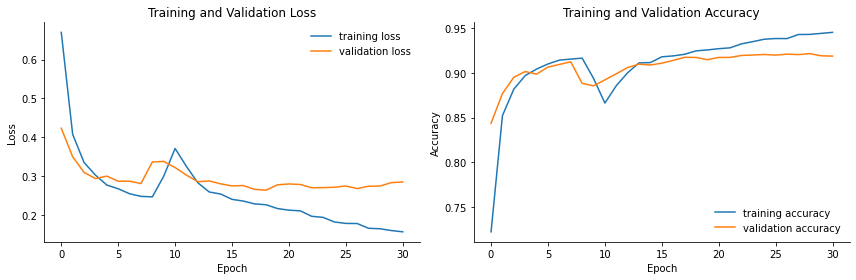

In [30]:
hist = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax = ax.ravel()

metrics = ['loss', 'accuracy']

for i, metric in enumerate(metrics):
    sns.lineplot(x=hist.index, y=f'{metric}', data=hist, ax=ax[i], label=f'training {metric}')
    sns.lineplot(x=hist.index, y=f'val_{metric}', data=hist, ax=ax[i], label=f'validation {metric}')
    ax[i].set(xlabel='Epoch', ylabel=f'{metric.title()}', title=f'Training and Validation {metric.title()}')
    ax[i].legend(frameon=False)

sns.despine()
plt.tight_layout();

## Generalização do modelo sobre a base de teste

In [31]:
# Carrega o melhor modelo
model = tf.keras.models.load_model('corona_tensorflow_best_model.h5')

_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Acurácia do modelo sobre os dados de teste: {accuracy:.2%}')

Acurácia do modelo sobre os dados de teste: 90.78%


## Matriz de confusão

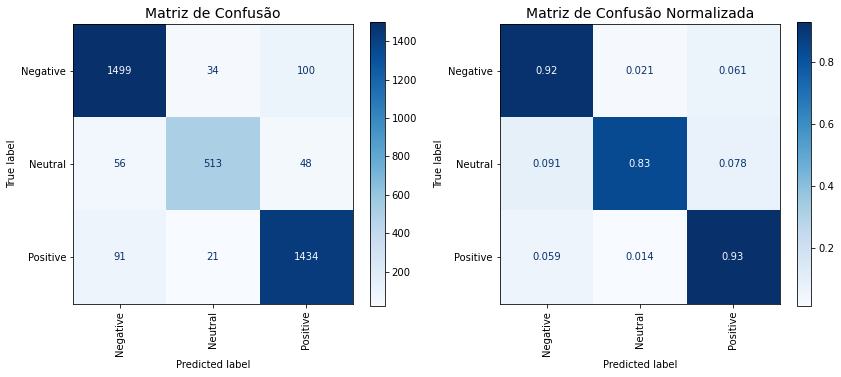

In [32]:
# Predições
preds = np.argmax(model.predict(X_test), axis=1)

# Plota a matriz de confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap='Blues', xticks_rotation='vertical', ax=ax[0])
ax[0].set_title('Matriz de Confusão', fontsize=14)

# Matriz de confusão dados normalizados (proporções)
cm_norm = confusion_matrix(y_test, preds, normalize='true')
ConfusionMatrixDisplay(cm_norm, display_labels=target_names).plot(cmap='Blues', xticks_rotation='vertical', ax=ax[1])
ax[1].set_title('Matriz de Confusão Normalizada', fontsize=14)

plt.tight_layout();

## _Classification report_

In [33]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.91      0.92      0.91      1633
     Neutral       0.90      0.83      0.87       617
    Positive       0.91      0.93      0.92      1546

    accuracy                           0.91      3796
   macro avg       0.91      0.89      0.90      3796
weighted avg       0.91      0.91      0.91      3796



Referências:

https://cce.puc-rio.br/sitecce/website/website.dll/folder?nCurso=bi-master-(traco)-business-intelligence-master-(traco)-sistemas-inteligentes-de-apoio-a-decisao-em-negocios&nInst=cce   
https://github.com/rrfsantos/Desafios-NLP   
https://www.kaggle.com/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc   

